<a href="https://colab.research.google.com/github/anirudh5698/Food-volume-estimation/blob/main/foodseg%2Bvolume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALLING REQUIRED ARCHITECTURE (PYTORCH,DETECTRON2,ETC)   

NOTE: WORKS ONLY ON GOOGLE COLAB

In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0jkbh2uo
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-0jkbh2uo
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# For reading annotations file
from pycocotools.coco import COCO

# utilities
from pprint import pprint # For beautiful print!
import os 

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from google.colab.patches import cv2_imshow

In [ ]:
from detectron2.data.datasets import register_coco_instances


DECLARING REQUIRED PATHS

In [ ]:
from google.colab import drive
#drive.mount("/content/drive")
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
training_images_path="/content/drive/MyDrive/dataset2/train"
testing_images_path="/content/drive/MyDrive/dataset2/val"
training_json="/content/drive/MyDrive/train.json"
testing_json="/content/drive/MyDrive/val.json"
eval_images_path="/content/drive/MyDrive/eval_data/Images"
eval_json="/content/drive/MyDrive/eval.json"

TRAINING AND TESTING DATA ANALYSIS

In [ ]:
train_coco=COCO(training_json)

loading annotations into memory...
Done (t=1.63s)
creating index...
index created!


In [ ]:
category_ids = train_coco.loadCats(train_coco.getCatIds())

category_names = [_["name"] for _ in category_ids]

pprint(", ".join(category_names))

category_ids


('Background, candy, egg tart, french fries, chocolate, biscuit, popcorn, '
 'pudding, ice cream, cheese butter, cake, wine, milkshake, coffee, juice, '
 'milk, tea, almond, red, cashew, dried cranberry, soy, walnut, peanut, egg, '
 'apple, date, apricot, avocado, banana, strawberry, cherry, blueberry, '
 'raspberry, mango, olives, peach, lemon, pear, fig, pineapple, grape, kiwi, '
 'melon, orange, watermelon, steak, pork, chicken duck, sausage, fried meat, '
 'lamb, sauce, crab, fish, shellfish, shrimp, soup, bread, corn, hamburg, '
 'pizza, hanamaki baozi, wonton dumplings, pasta, noodles, rice, pie, tofu, '
 'eggplant, potato, garlic, cauliflower, tomato, kelp, seaweed, spring onion, '
 'rape, ginger, okra, lettuce, pumpkin, cucumber, white radish, carrot, '
 'asparagus, bamboo, broccoli, celery, cilantro mint, snow peas, cabbage, '
 'bean, onion, pepper, green beans, French beans, king oyster mushroom, '
 'shiitake, enoki mushroom, oyster mushroom, white button mushroom, salad, '
 

[{'id': 0, 'name': 'Background', 'supercategory': 'Background'},
 {'id': 1, 'name': 'candy', 'supercategory': 'candy'},
 {'id': 2, 'name': 'egg tart', 'supercategory': 'egg tart'},
 {'id': 3, 'name': 'french fries', 'supercategory': 'french fries'},
 {'id': 4, 'name': 'chocolate', 'supercategory': 'chocolate'},
 {'id': 5, 'name': 'biscuit', 'supercategory': 'biscuit'},
 {'id': 6, 'name': 'popcorn', 'supercategory': 'popcorn'},
 {'id': 7, 'name': 'pudding', 'supercategory': 'pudding'},
 {'id': 8, 'name': 'ice cream', 'supercategory': 'ice cream'},
 {'id': 9, 'name': 'cheese butter', 'supercategory': 'cheese butter'},
 {'id': 10, 'name': 'cake', 'supercategory': 'cake'},
 {'id': 11, 'name': 'wine', 'supercategory': 'wine'},
 {'id': 12, 'name': 'milkshake', 'supercategory': 'milkshake'},
 {'id': 13, 'name': 'coffee', 'supercategory': 'coffee'},
 {'id': 14, 'name': 'juice', 'supercategory': 'juice'},
 {'id': 15, 'name': 'milk', 'supercategory': 'milk'},
 {'id': 16, 'name': 'tea', 'supercat

In [ ]:
no_images_per_category = {}

for n, i in enumerate(train_coco.getCatIds()):
  imgIds = train_coco.getImgIds(catIds=i)
  label = category_names[n]
  no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))

no_images_per_category


{'Background': 4982,
 'French beans': 253,
 'almond': 70,
 'apple': 106,
 'apricot': 22,
 'asparagus': 187,
 'avocado': 57,
 'bamboo': 3,
 'banana': 100,
 'bean': 24,
 'biscuit': 218,
 'blueberry': 152,
 'bread': 990,
 'broccoli': 703,
 'cabbage': 94,
 'cake': 333,
 'candy': 21,
 'carrot': 881,
 'cashew': 13,
 'cauliflower': 157,
 'celery': 164,
 'cheese butter': 276,
 'cherry': 159,
 'chicken duck': 848,
 'chocolate': 49,
 'cilantro mint': 636,
 'coffee': 127,
 'corn': 343,
 'crab': 14,
 'cucumber': 369,
 'date': 7,
 'dried cranberry': 18,
 'egg': 223,
 'egg tart': 3,
 'eggplant': 19,
 'enoki mushroom': 6,
 'fig': 21,
 'fish': 258,
 'french fries': 166,
 'fried meat': 154,
 'garlic': 73,
 'ginger': 23,
 'grape': 123,
 'green beans': 152,
 'hamburg': 5,
 'hanamaki baozi': 19,
 'ice cream': 635,
 'juice': 129,
 'kelp': 1,
 'king oyster mushroom': 10,
 'kiwi': 38,
 'lamb': 71,
 'lemon': 423,
 'lettuce': 403,
 'mango': 43,
 'melon': 20,
 'milk': 45,
 'milkshake': 80,
 'noodles': 187,
 'ok

LOADING DATASET

In [ ]:
register_coco_instances("training",{},training_json,training_images_path)
register_coco_instances("testing",{},testing_json,testing_images_path)
register_coco_instances("evaluation",{},eval_json,eval_images_path)

MODEL CONFIGURATION AND TRAINING THE MODEL

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("training",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS="/content/drive/MyDrive/model_final(1).pth"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 20000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 103



In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/09 21:36:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

AssertionError: ignored

In [ ]:
microcontroller_metadata = MetadataCatalog.get("training")

PREDICTION

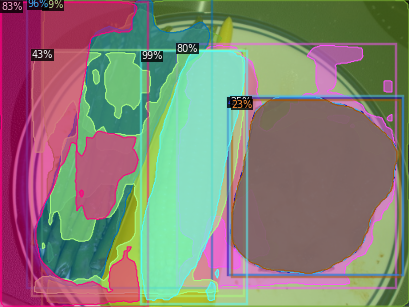

In [ ]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS="/content/drive/MyDrive/model_final (1).pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("testing", )

predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/test.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
cv2_imshow(v.get_image()[:, :, ::-1])



MODEL EVALUATION

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("evaluation", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "evaluation")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)


GENERATING JSON FILE FROM PREDICTED IMAGE

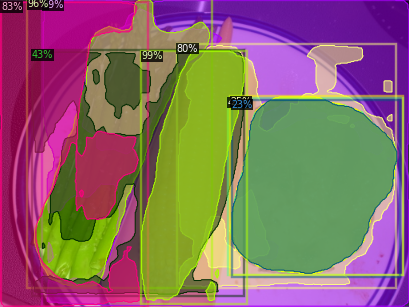

In [ ]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS="/content/drive/MyDrive/model_final (1).pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("testing", )

predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/test.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
cv2_imshow(v.get_image()[:, :, ::-1])



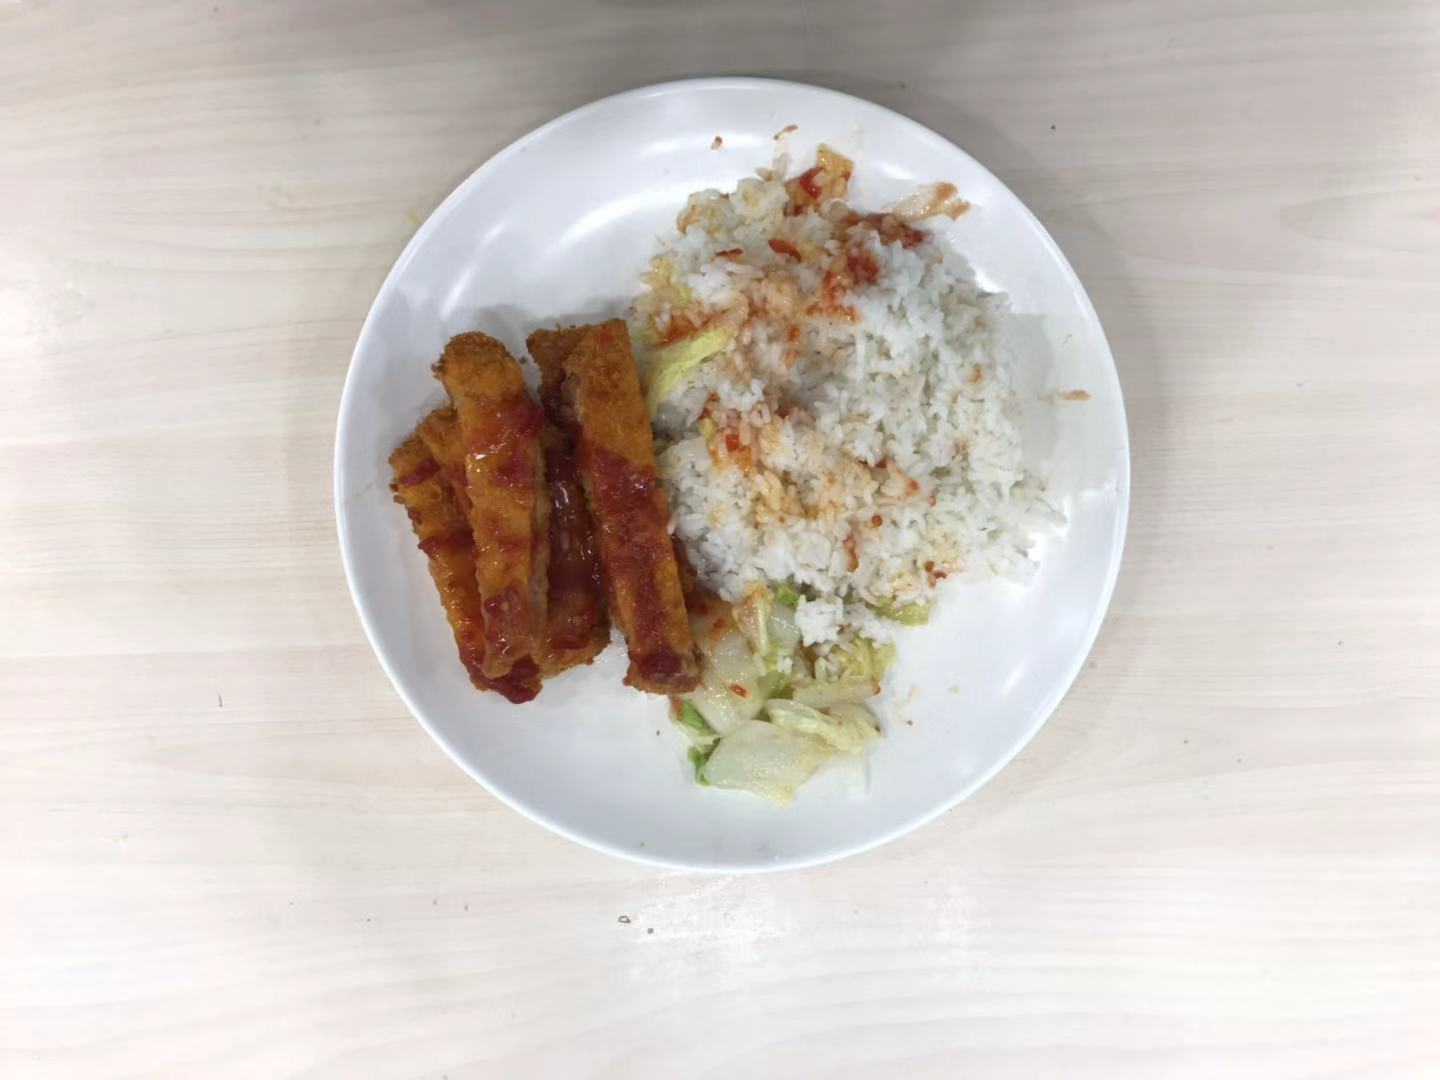

In [ ]:
img=cv2.imread("/content/test.jpg")
cv2_imshow(img)


In [ ]:
def getList(dict):
    return dict.keys()
dict = outputs
print(getList(dict))
a=outputs["instances"]
b=a.get_fields()
scores=b['scores'].cpu().numpy()
rois=b['pred_boxes'].tensor.cpu().numpy()
pred_class=b['pred_classes'].cpu().numpy()
pred_masks=b['pred_masks'].cpu().numpy()


dict_keys(['instances'])


In [ ]:
min_conf=0.30

(9, 384, 512)
confidence:  96.1719810962677     Class:  asparagus
confidence:  40.34489691257477     Class:  pork


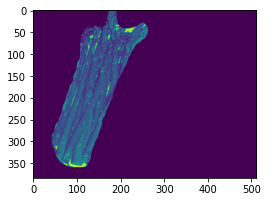

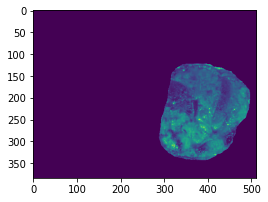

In [ ]:
import tensorflow as tf
from skimage import io
masking=pred_masks
image_list=[]
image_names=[]

masking=masking.astype(int)
print(masking.shape)
for i in range(masking.shape[0]):
  if scores[i] > min_conf and category_names[pred_class[i]]!="Background":
    temp= io.imread('/content/test.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * masking[i,:,:]
    plt.figure(figsize=(4,4))
    
    
    temp=cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    globals()[f"temp_{i}"] = temp
    image_list.append(i)
    b=cv2.countNonZero(temp)
    print("confidence: ",100*scores[i],"   ","Class: ",category_names[pred_class[i]])
    image_names.append(category_names[pred_class[i]])
    plt.imshow(temp)

In [ ]:
!pip install imantics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16033 sha256=e06308e1e79a204bbea5ee5e83867a1022b7d481457222e2c79697c0f0a79027
  Stored in directory: /root/.cache/pip/wheels/da/7c/3e/296fe3ed4eb3bd713e91dee0d0549f12f316d49939a64bdc96
Successfully built imantics


In [ ]:
import numpy as np
from imantics import Polygons, Mask
for i in image_list:
  temp=globals()[f"temp_{i}"]
  globals()[f"polygons_points_{i}"] = Mask(temp).polygons()
  globals()[f"polygons_cords_{i}"]=globals()[f"polygons_points_{i}"].points[0]




In [ ]:
print(image_names)
print(image_list)

['asparagus', 'pork']
[2, 6]


In [ ]:
plate_cords=[[38.054054054054056,136.64864864864865],

[18.16216216216216,251.64864864864865],

[65.72972972972974,379.6756756756757],



[510.2702702702703,252.54054054054055]
]

In [ ]:
for i in plate_cords:
  i[0]=int(i[0])
  i[1]=int(i[1])
print(plate_cords)

[[38, 136], [18, 251], [65, 379], [510, 252]]


In [ ]:
for i in image_list:
  globals()[f"polygons_cords_{i}"]=globals()[f"polygons_cords_{i}"].tolist()


In [ ]:
plate ={
      "label":"plate",
      "line_color" : "null",
      "fill_color": "null",
      "points" : plate_cords,
     "shape_type" : "polygon"
    
    
}

In [ ]:
shapes=[]
j=0
for i in image_list:
  
  a={
      "label":str(image_names[j]),
      "line_color" : "null",
      "fill_color": "null",
      "points" : globals()[f"polygons_cords_{i}"],
     "shape_type" : "polygon"
     
       
  }
  shapes.append(a)
  j=j+1
shapes.append(plate)


In [ ]:
import json
data={
    "version": "3.5.0",
    "flags": {},
    "shapes" : shapes,
    "lineColor": [
    0,
    255,
    0,
    128
  ],
  "fillColor": [
    255,
    0,
    0,
    128
  ]

      }
json_object = json.dumps(data, indent = 4)
with open("data.json", "w") as outfile:
    outfile.write(json_object)


VOLUME DETECTION 

In [ ]:
cd "/content/drive/MyDrive/Food-Volume-Estimation/Volume Estimation"

/content/drive/MyDrive/Food-Volume-Estimation/Volume Estimation


In [ ]:
!python demo.py --img "/content/test.jpg"  --json "/content/drive/MyDrive/Food-Volume-Estimation/Volume Estimation/data.json" --output "/content/drive/MyDrive/Food-Volume-Estimation/Volume Estimation/output"


demo.py:63: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = torch.autograd.Variable(image, volatile=True).cuda()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[[38, 136], [18, 251], [65, 379], [510, 252]]
0.06784260515603799 0.02197802197802198
Volume:
{'asparagus': 0.07905377596946886, 'pork': 647.5947956942136}
unit: cm^3
Traceback (most recent call last):
  File "demo.py"